In [1]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
class ProductSearchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # Extract data
        product_id = row['id']
        product_desc = row['description']
        product_cluster = row['label']

        # Get all queries
        product_queries = row[['query_1', 'query_2', 'query_3', 'query_4', 'query_5']].values

        # Randomly select one query for training
        query = np.random.choice(product_queries)

        return query, product_desc, product_id, product_cluster

In [5]:
from google.colab import files
uploaded = files.upload()

Saving beauty_products_with_sample_queries.csv to beauty_products_with_sample_queries.csv


In [6]:
df = pd.read_csv("beauty_products_with_sample_queries.csv")

In [7]:
df.head()

,id,title,description,label,query_1,query_2,query_3,query_4,query_5
0,B0C523T7C5,L’Oréal Paris Paradise Enchanted Scented Eyesh...,LOreal Paris presents the Paradise Enchanted E...,49,warm eyeshadow palette,fruity scented eye shadow,enchanting eye makeup,eye shadow with coral tones,step by step eye makeup guide
1,B07939KVKK,Viva Naturals Charcoal Face Mask Set (8 Pack) ...,Take your skin care routine to the next level ...,45,charcoal face mask set,hydrating sheet masks,glowy skin face mask,dermatologist approved facial masks,sheet mask set with essential oils
2,B08ZDDGBDP,9 Pcs Satin Hair Scrunchies Soft Elastic Hair ...,Product Information Material satin Size4 in Co...,56,satin scrunchies set,colorful hair ties,gentle hair accessories,trendy ponytail holders,satin hairbands variety pack
3,B09577STQ1,RikView Press on Nails Short French Tip Nails ...,RikView We focus on the design and sales of fa...,15,fashionable fake nails set,salon comparable false nails,eco-friendly press on nails,reusable square nails,easy application nail art
4,B007GMTJRK,"Kevyn Aucoin The Volume Mascara, Black: Precis...",Kevyn Aucoin The Volume Mascara Black A volume...,36,volumizing tubing mascara,Kevyn Aucoin mascara,mascara for defined lashes,tubing mascara with jojoba oil,smudge-resistant lash lengthener


In [8]:
train_dataset, val_dataset = train_test_split(df, test_size=0.2, random_state=3478)
train_dataset.reset_index(drop=True, inplace=True)
val_dataset.reset_index(drop=True, inplace=True)

In [9]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [10]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)

    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)

        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [11]:
def batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1):
    """
    Sample hard negatives from the current batch, ensuring negatives come from different clusters.

    Args:
        product_ids (list): List of product IDs in the batch.
        cluster_ids (list): List of corresponding cluster IDs in the batch.
        product_embeddings (torch.Tensor): Tensor of product embeddings in the batch [batch_size, embed_dim].
        num_negatives (int): Number of negatives per query.

    Returns:
        neg_embeddings (torch.Tensor): Tensor of hard negative product embeddings [batch_size, num_negatives, embed_dim].
    """
    batch_size = len(product_ids)
    neg_samples = []

    for i in range(batch_size):
        # Get current cluster ID
        current_cluster = cluster_ids[i]

        # Find indices of products in the batch from a different cluster
        negative_indices = [j for j in range(batch_size) if cluster_ids[j] != current_cluster]

        # Sample negatives
        sampled_negatives = random.sample(negative_indices, num_negatives)

        # Store their embeddings
        neg_samples.append(product_embeddings[sampled_negatives])

    # Stack negatives into a tensor [batch_size, num_negatives, embed_dim]
    neg_embeddings = torch.stack(neg_samples).to(product_embeddings.device)

    return neg_embeddings

In [12]:
def evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, k=10, device='cuda'):
    """
    Evaluate the model on the evaluation dataset

    Args:
        query_encoder: Query encoder model
        product_encoder: Product encoder model
        eval_dataset: Evaluation dataset
        tokenizer: Tokenizer
        query_max_len: Maximum query length
        product_max_len: Maximum product description length
        k: Number of top results to consider for metrics
        device: Device to use for computations
    """
    query_encoder.eval()
    product_encoder.eval()

    # Create evaluation dataloader
    eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=8, shuffle=False)

    # First pass: encode all products
    all_product_ids = []
    all_product_embeddings = []

    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Encoding Products"):
            _, product_descs, product_ids, _ = batch_data

            product_tokens = tokenizer(
                product_descs,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=product_max_len
            )

            product_embeddings = product_encoder(product_tokens)
            product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

            all_product_ids.extend(product_ids)
            all_product_embeddings.append(product_embeddings.cpu())  # Move to CPU to save GPU memory

    # Concatenate all product embeddings
    all_product_embeddings = torch.cat(all_product_embeddings, dim=0)

    # Second pass: evaluate queries
    total_queries = 0
    hits_at_k = 0
    mrr = 0.0  # Mean Reciprocal Rank

    with torch.no_grad():
        for batch_data in tqdm(eval_dataloader, desc="Evaluating Queries"):
            queries, _, product_ids, _ = batch_data

            query_tokens = tokenizer(
                queries,
                padding=True,
                truncation=True,
                return_tensors="pt",
                max_length=query_max_len
            )

            query_embeddings = query_encoder(query_tokens)
            query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)

            # Move query embeddings to CPU for comparison with all products
            query_embeddings_cpu = query_embeddings.cpu()

            # Compute similarities with all products
            similarities = query_embeddings_cpu @ all_product_embeddings.T

            # Get top-k indices
            _, top_indices = torch.topk(similarities, k=k, dim=1)

            # Convert to list for evaluation
            for i, (query_id, true_product_id) in enumerate(zip(range(len(queries)), product_ids)):
                total_queries += 1
                top_k_product_ids = [all_product_ids[idx] for idx in top_indices[i].tolist()]

                # Check if true product is in top-k
                if true_product_id in top_k_product_ids:
                    hits_at_k += 1
                    # Calculate reciprocal rank
                    rank = top_k_product_ids.index(true_product_id) + 1
                    mrr += 1.0 / rank

    # Calculate metrics
    hits_at_k_rate = hits_at_k / total_queries if total_queries > 0 else 0
    mrr = mrr / total_queries if total_queries > 0 else 0

    print(f"Evaluation Metrics:")
    print(f"Hits@{k}: {hits_at_k_rate:.4f}")
    print(f"MRR: {mrr:.4f}")

    return hits_at_k_rate, mrr

In [13]:
def in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings, temperature=0.1):
    """
    Compute in-batch negative sampling loss (InfoNCE loss) with hard negatives.

    Args:
        query_embeddings: Query embeddings [batch_size, embed_dim]
        product_embeddings: Product embeddings [batch_size, embed_dim]
        negative_embeddings: Hard negative product embeddings [batch_size, embed_dim]
        temperature: Temperature parameter for softmax.

    Returns:
        loss: InfoNCE loss
    """
    batch_size = query_embeddings.shape[0]

    # Squeeze negative embeddings to remove the unnecessary dimension
    negative_embeddings = negative_embeddings.squeeze(1)

    # Compute similarity scores
    positive_sim = (query_embeddings * product_embeddings).sum(dim=1) / temperature
    negative_sim = (query_embeddings @ negative_embeddings.T) / temperature  # Hard negatives

    # Stack positives and negatives
    logits = torch.cat([positive_sim.unsqueeze(1), negative_sim], dim=1)

    # Labels: First column (positive pair) is correct
    labels = torch.zeros(batch_size, dtype=torch.long, device=query_embeddings.device)

    # Compute loss
    loss = torch.nn.functional.cross_entropy(logits, labels)

    return loss

In [14]:
def train_embedding_model(dataset, num_epochs=10, learning_rate=1e-4, eval_dataset=None, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = ProductSearchDataset(dataset)
    eval_dataset = ProductSearchDataset(eval_dataset)

    embed_size = 512
    output_embed_size = 128
    query_max_len = 32
    product_max_len = 512
    batch_size = 8

    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    # Initialize encoders
    query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)
    product_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=embed_size, output_embed_dim=output_embed_size).to(device)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(list(query_encoder.parameters()) + list(product_encoder.parameters()), lr=learning_rate)

    scaler = torch.amp.GradScaler(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    total_steps = len(dataloader) * num_epochs
    main_progress_bar = tqdm(total=total_steps, desc="Training Progress", position=0)

    best_hits = 0
    patience_counter = 0
    best_query_encoder_weights = None
    best_product_encoder_weights = None


    hits_log = []
    mrr_log = []

    for epoch in range(num_epochs):
        # Early stopping check
        if patience_counter == patience:
            break

        query_encoder.train()
        product_encoder.train()
        epoch_loss = []

        epoch_desc = f"Epoch {epoch+1}/{num_epochs}"
        epoch_progress = tqdm(dataloader, desc=epoch_desc, leave=False, position=1)

        for batch_idx, batch_data in enumerate(epoch_progress):
            queries, product_descs, product_ids, cluster_ids = batch_data

            query_tokens = tokenizer(queries, padding=True, truncation=True, return_tensors="pt", max_length=query_max_len).to(device)
            product_tokens = tokenizer(product_descs, padding=True, truncation=True, return_tensors="pt", max_length=product_max_len).to(device)

            with torch.amp.autocast(device.type):
                query_embeddings = query_encoder(query_tokens)
                product_embeddings = product_encoder(product_tokens)

                query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=1)
                product_embeddings = torch.nn.functional.normalize(product_embeddings, p=2, dim=1)

                # Get hard negatives from the batch
                negative_embeddings = batch_hard_negative_sampling(product_ids, cluster_ids, product_embeddings, num_negatives=1)

                loss = in_batch_negative_sampling_loss(query_embeddings, product_embeddings, negative_embeddings)

            epoch_loss.append(loss.item())

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            main_progress_bar.update(1)
            epoch_progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = np.mean(epoch_loss)
        print(f"\nEpoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

        scheduler.step(avg_loss)

        if eval_dataset is not None:
            print("\nEvaluating model...")
            hits_in_top_k, mrr = evaluate_model(query_encoder, product_encoder, eval_dataset, tokenizer, query_max_len, product_max_len, device=device)
            if hits_in_top_k > best_hits:
                best_hits = hits_in_top_k
                best_query_encoder_weights = query_encoder.state_dict()
                best_product_encoder_weights = product_encoder.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            hits_log.append(hits_in_top_k)
            mrr_log.append(mrr)

    main_progress_bar.close()

    # Load the model weights with the best validation hits
    query_encoder.load_state_dict(best_query_encoder_weights)
    product_encoder.load_state_dict(best_product_encoder_weights)

    return query_encoder, product_encoder, hits_log, mrr_log

In [15]:
query_encoder, product_encoder, hits_in_top_k_history, mrr_history = train_embedding_model(train_dataset, num_epochs=100, eval_dataset=val_dataset, patience=10)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Training Progress:   0%|          | 0/3400 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 1/100, Average Loss: 2.2048

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.2206
MRR: 0.0568


Epoch 2/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 2/100, Average Loss: 2.1656

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.1912
MRR: 0.0538


Epoch 3/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 3/100, Average Loss: 2.0689

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4118
MRR: 0.1170


Epoch 4/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 4/100, Average Loss: 1.9531

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3676
MRR: 0.1116


Epoch 5/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 5/100, Average Loss: 1.9394

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.3235
MRR: 0.0948


Epoch 6/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 6/100, Average Loss: 1.9161

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4559
MRR: 0.1258


Epoch 7/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 7/100, Average Loss: 1.7582

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.4853
MRR: 0.1861


Epoch 8/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 8/100, Average Loss: 1.5995

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5294
MRR: 0.1928


Epoch 9/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 9/100, Average Loss: 1.6744

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5588
MRR: 0.1502


Epoch 10/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 10/100, Average Loss: 1.5607

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5588
MRR: 0.2083


Epoch 11/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 11/100, Average Loss: 1.3979

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6912
MRR: 0.2383


Epoch 12/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 12/100, Average Loss: 1.4910

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5294
MRR: 0.2084


Epoch 13/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 13/100, Average Loss: 1.3463

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5588
MRR: 0.1922


Epoch 14/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 14/100, Average Loss: 1.3866

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.5882
MRR: 0.2545


Epoch 15/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 15/100, Average Loss: 1.3064

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6324
MRR: 0.2607


Epoch 16/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 16/100, Average Loss: 1.2104

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6618
MRR: 0.2104


Epoch 17/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 17/100, Average Loss: 1.0347

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7353
MRR: 0.3089


Epoch 18/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 18/100, Average Loss: 1.1149

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6029
MRR: 0.2788


Epoch 19/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 19/100, Average Loss: 1.0418

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6176
MRR: 0.2786


Epoch 20/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 20/100, Average Loss: 1.0786

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6912
MRR: 0.2840


Epoch 21/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 21/100, Average Loss: 0.9707

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6912
MRR: 0.3235


Epoch 22/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 22/100, Average Loss: 0.9190

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7206
MRR: 0.3448


Epoch 23/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 23/100, Average Loss: 0.9575

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7059
MRR: 0.3297


Epoch 24/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 24/100, Average Loss: 0.9339

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7647
MRR: 0.3059


Epoch 25/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 25/100, Average Loss: 0.9101

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7647
MRR: 0.3924


Epoch 26/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 26/100, Average Loss: 0.7955

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7353
MRR: 0.3707


Epoch 27/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 27/100, Average Loss: 0.8347

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.6765
MRR: 0.3126


Epoch 28/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 28/100, Average Loss: 0.8198

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7500
MRR: 0.3342


Epoch 29/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 29/100, Average Loss: 0.8612

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7500
MRR: 0.3659


Epoch 30/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 30/100, Average Loss: 0.8429

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7059
MRR: 0.3930


Epoch 31/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 31/100, Average Loss: 0.8203

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8088
MRR: 0.3744


Epoch 32/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 32/100, Average Loss: 0.8126

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7941
MRR: 0.3702


Epoch 33/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 33/100, Average Loss: 0.7908

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8235
MRR: 0.3808


Epoch 34/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 34/100, Average Loss: 0.7848

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8529
MRR: 0.3982


Epoch 35/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 35/100, Average Loss: 0.8025

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8235
MRR: 0.4213


Epoch 36/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 36/100, Average Loss: 0.7599

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8382
MRR: 0.4368


Epoch 37/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 37/100, Average Loss: 0.8268

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7647
MRR: 0.4244


Epoch 38/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 38/100, Average Loss: 0.7747

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7794
MRR: 0.4438


Epoch 39/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 39/100, Average Loss: 0.7289

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7353
MRR: 0.4001


Epoch 40/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 40/100, Average Loss: 0.7795

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7794
MRR: 0.4325


Epoch 41/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 41/100, Average Loss: 0.7619

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7500
MRR: 0.4110


Epoch 42/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 42/100, Average Loss: 0.7471

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7941
MRR: 0.4304


Epoch 43/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 43/100, Average Loss: 0.7873

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.8235
MRR: 0.4152


Epoch 44/100:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 44/100, Average Loss: 0.7588

Evaluating model...


Encoding Products:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating Queries:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluation Metrics:
Hits@10: 0.7941
MRR: 0.3977


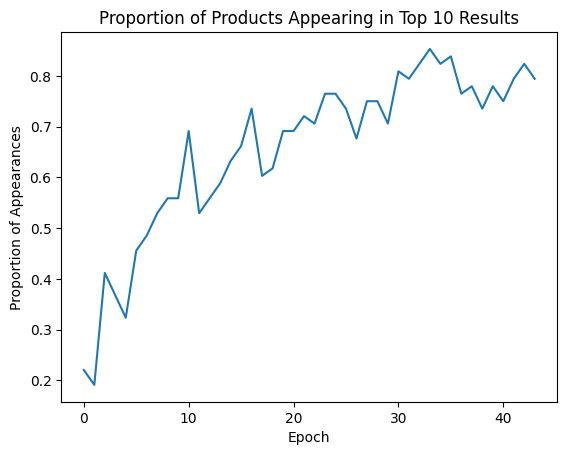

In [16]:
plt.plot(hits_in_top_k_history)
plt.xlabel("Epoch")
plt.ylabel("Proportion of Appearances")
plt.title("Proportion of Products Appearing in Top 10 Results")
plt.show()

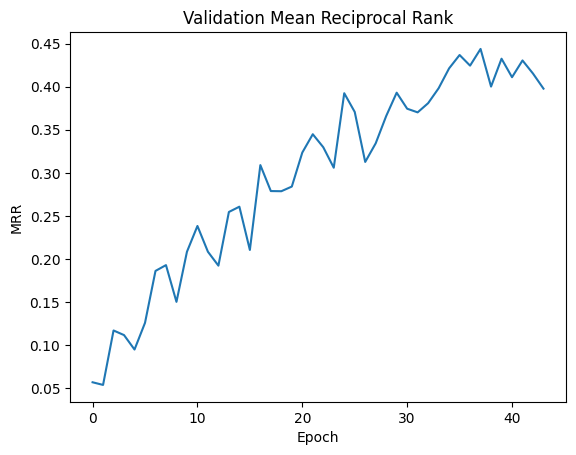

In [17]:
plt.plot(mrr_history)
plt.xlabel("Epoch")
plt.ylabel("MRR")
plt.title("Validation Mean Reciprocal Rank")
plt.show()

In [20]:
from google.colab import files

# Save models
torch.save(query_encoder.state_dict(), 'beauty_products_query_encoder_v3.pt')
torch.save(product_encoder.state_dict(), 'beauty_products_description_encoder_v3.pt')

# Download files
files.download('beauty_products_query_encoder_v3.pt')
files.download('beauty_products_description_encoder_v3.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>